# Baseline Model

L’objectif de ce notebook est de mettre en place un **modèle de référence (baseline)** pour le projet de détection de fraude. Ce modèle servira de point de comparaison pour toutes les améliorations futures et permettra d’évaluer rapidement la performance des différentes approches.

Pour cette étape initiale, nous nous concentrons sur trois algorithmes de **gradient boosting**, réputés pour leur efficacité sur des problèmes de classification avec des données structurées :

1. **XGBoost** – un modèle performant et largement utilisé pour les problèmes de classification et de régression.  
2. **LightGBM** – optimisé pour les grands ensembles de données, offrant rapidité et efficacité mémoire.  
3. **CatBoost** – particulièrement efficace pour gérer les variables catégorielles sans avoir besoin d’un encodage manuel complexe.

Ce notebook inclura :  
- La préparation des données (encodage des variables catégorielles, sélection des features).  
- L’entraînement de chaque modèle sur les données d’entraînement.  
- L’évaluation des modèles avec des métriques adaptées à la détection de fraude (précision, rappel, F1-score, AUC-ROC).  
- Une comparaison des performances pour identifier le modèle de référence le plus performant sur cet ensemble de données.


In [41]:
import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from all_functions import *
import joblib
import numpy as np
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [28]:
df_train = pd.read_csv('../Data/train_reduced.csv')

In [29]:
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])

type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

In [30]:
# colonnes du dataframe qui ne sont pas dans cat_cols
num_cols = [col for col in df_train.columns if col not in cat_cols + id_cols + [target]]
print(f"Nombre de colonnes numériques: {len(num_cols)}")
# num_cols

Nombre de colonnes numériques: 157


In [31]:
type_map = {c: 'float64' for c in num_cols}
df_train[num_cols] = df_train[num_cols].astype(type_map, copy=False)

In [32]:
missing_cols = top_missing_cols(df_train, n=None,  thresh=50)

Il y a 142 colonnes dans ce jeu de données contenant des valeurs manquantes.
Il y a 60 colonnes dont le pourcentage de valeurs manquantes est supérieur à 50%.


In [33]:
missing_cols

,col,missing_percent
0,id_08,99.127070
1,id_07,99.127070
2,dist2,93.628374
3,D7,93.409930
4,D13,89.509263
...,...,...
204,id_36,0.000000
205,id_37,0.000000
206,id_38,0.000000
207,DeviceType,0.000000


### Suppression des colonnes avec 80% de valeurs manquantes

In [34]:
df_train = df_train.drop(columns=missing_cols[missing_cols['missing_percent'] >= 80]['col'])

In [35]:
top_missing_cols(df_train, thresh=80)

Il y a 116 colonnes dans ce jeu de données contenant des valeurs manquantes.
Il y a 0 colonnes dont le pourcentage de valeurs manquantes est supérieur à 80%.


,col,missing_percent
0,V240,77.913435
1,V258,77.913435
2,V241,77.913435
3,V260,77.913435
4,V223,77.913435
5,V226,77.913435
6,V218,77.913435
7,V229,77.913435
8,V264,77.913435
9,V277,77.913435


### Encodage des variables catégorielles

Dans ce projet, j’ai choisi d’utiliser pd.factorize() pour encoder les variables catégorielles.
Ce type d’encodage (Label Encoding) est particulièrement adapté aux modèles basés sur des arbres tels que XGBoost, CatBoost et LightGBM, car ces algorithmes sont capables de traiter efficacement des valeurs entières représentant des catégories sans être influencés par un ordre numérique artificiel.

L’objectif est donc de tester la performance de ces modèles avec un encodage compact et rapide, tout en conservant une bonne interprétation des variables catégorielles.

In [36]:
for col in df_train.columns:
    if col in cat_cols:
        # Label encode categorical columns
        encoded, _ = pd.factorize(df_train[col], sort=True)
        
        # Check if values fit in int16
        if encoded.max() > 32000:
            print(col, 'needs int32 datatype')
            df_train[col] = encoded.astype('int32')
        else:
            df_train[col] = encoded.astype('int16')


In [37]:
rem_cols = []
rem_cols.extend(['TransactionID', 'TransactionDT'])

Nous créons de nouvelles features temporelles D1n à D15n.
Pour chaque colonne D1 à D15, on soustrait TransactionDT (converti en jours) afin de recentrer les variables temporelles par rapport à la date de la transaction.
Cette transformation permet aux modèles basés sur les arbres (XGBoost, CatBoost, LightGBM) de mieux capturer les patterns temporels liés à la fraude.

In [38]:
new_cols = {}
for i in range(1, 16):
    orig_col = 'D' + str(i)
    if orig_col in df_train.columns:
        new_cols[orig_col + 'n'] = df_train[orig_col] - df_train['TransactionDT'] / np.float32(24*60*60)

# Ajouter toutes les colonnes en une seule fois
df_train = pd.concat([df_train, pd.DataFrame(new_cols)], axis=1)


### Scaling des variables numériques

In [39]:

cols = [col for col in df_train.columns if col not in rem_cols]

for col in cols:
    if col not in cat_cols:
        # Min-Max scaling
        scaled = (df_train[col] - df_train[col].min()) / (df_train[col].max() - df_train[col].min())
        scaled.fillna(-1, inplace=True)  # Remplacer les NaN par -1
        df_train[col] = scaled


In [40]:
from sklearn.model_selection import train_test_split

# X = features, y = target
X = df_train.drop(columns=['isFraud'])  # exemple, ta target = 'isFraud'
y = df_train['isFraud']

# Split stratifié pour garder la proportion des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% pour le test
    random_state=42,        # pour reproductibilité
    stratify=y              # stratification selon la target
)

print("Proportion de 1 dans le train:", y_train.mean())
print("Proportion de 1 dans le test:", y_test.mean())


Proportion de 1 dans le train: 0.03498916246147594
Proportion de 1 dans le test: 0.0349933958749619


### Entrainement et comparaison des modèles

XGBoost fonction

In [42]:
def train_xgb(X_train, y_train, X_test, y_test, cols):
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = neg / pos if pos > 0 else 1.0

    clf = XGBClassifier(
        n_estimators=1000,
        max_depth=10,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.5,
        missing=-1,
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight,
        tree_method='hist',
        random_state=42
    )

    clf.fit(X_train[cols], y_train)
    y_pred_proba = clf.predict_proba(X_test[cols])[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    return score, clf, fpr, tpr, cm

Fonction CatBoost

In [43]:
def train_catboost(X_train, y_train, X_test, y_test, cols):
    clf = CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.02,
        eval_metric='AUC',
        random_seed=42,
        verbose=100,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum()
    )

    clf.fit(X_train[cols], y_train, eval_set=(X_test[cols], y_test), verbose=100)
    y_pred_proba = clf.predict_proba(X_test[cols])[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    return score, clf, fpr, tpr, cm

Fonction LightGBM

In [44]:
def train_lightgbm(X_train, y_train, X_test, y_test, cols):
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.5,
        random_state=42,
        class_weight={0: 1, 1: pos_weight}
    )

    clf.fit(X_train[cols], y_train)
    y_pred_proba = clf.predict_proba(X_test[cols])[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    return score, clf, fpr, tpr, cm

Fonction pour comparer les modèles

In [ ]:
def compare_models(X_train, y_train, X_test, y_test, cols, save_path="best_model.joblib"):
    results = {}
    metrics = {}

    # ---- XGBoost ----
    xgb_score, xgb_model, xgb_fpr, xgb_tpr, xgb_cm = train_xgb(X_train, y_train, X_test, y_test, cols)
    results['XGBoost'] = xgb_score
    metrics['XGBoost'] = {'fpr': xgb_fpr, 'tpr': xgb_tpr, 'cm': xgb_cm}

    # ---- CatBoost ----
    cat_score, cat_model, cat_fpr, cat_tpr, cat_cm = train_catboost(X_train, y_train, X_test, y_test, cols)
    results['CatBoost'] = cat_score
    metrics['CatBoost'] = {'fpr': cat_fpr, 'tpr': cat_tpr, 'cm': cat_cm}

    # ---- LightGBM ----
    lgb_score, lgb_model, lgb_fpr, lgb_tpr, lgb_cm = train_lightgbm(X_train, y_train, X_test, y_test, cols)
    results['LightGBM'] = lgb_score
    metrics['LightGBM'] = {'fpr': lgb_fpr, 'tpr': lgb_tpr, 'cm': lgb_cm}

    # ---- Résumé ----
    print("\nROC-AUC Scores:")
    for name, score in results.items():
        print(f"{name}: {score:.5f}")

    # ---- Sauvegarde du meilleur modèle ----
    best_model_name = max(results, key=results.get)
    best_model = {
        'name': best_model_name,
        'model': {
            'XGBoost': xgb_model,
            'CatBoost': cat_model,
            'LightGBM': lgb_model
        }[best_model_name],
        'score': results[best_model_name]
    }

    # Sauvegarde avec joblib
    joblib.dump(best_model, save_path)
    print(f"\nBest model saved: {best_model_name} (ROC-AUC = {best_model['score']:.5f})")
    print(f"Saved to: {save_path}")

    return results, metrics, best_model

In [46]:
cols_to_use = X_train.columns.tolist()
results, metrics, best_model = compare_models(X_train, y_train, X_test, y_test, cols_to_use)


0:	test: 0.8478822	best: 0.8478822 (0)	total: 1.45s	remaining: 24m 3s
100:	test: 0.8998529	best: 0.8998529 (100)	total: 2m 24s	remaining: 21m 29s
200:	test: 0.9179392	best: 0.9179392 (200)	total: 4m 39s	remaining: 18m 30s
300:	test: 0.9279420	best: 0.9279420 (300)	total: 6m 52s	remaining: 15m 59s
400:	test: 0.9343735	best: 0.9343735 (400)	total: 9m 1s	remaining: 13m 28s
500:	test: 0.9395169	best: 0.9395169 (500)	total: 12m 24s	remaining: 12m 21s
600:	test: 0.9438122	best: 0.9438122 (600)	total: 15m 17s	remaining: 10m 9s
700:	test: 0.9491772	best: 0.9491772 (700)	total: 17m 31s	remaining: 7m 28s
800:	test: 0.9554935	best: 0.9554935 (800)	total: 19m 52s	remaining: 4m 56s
900:	test: 0.9586033	best: 0.9586033 (900)	total: 22m 17s	remaining: 2m 26s
999:	test: 0.9608306	best: 0.9608306 (999)	total: 24m 37s	remaining: 0us

bestTest = 0.9608306481
bestIteration = 999

[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

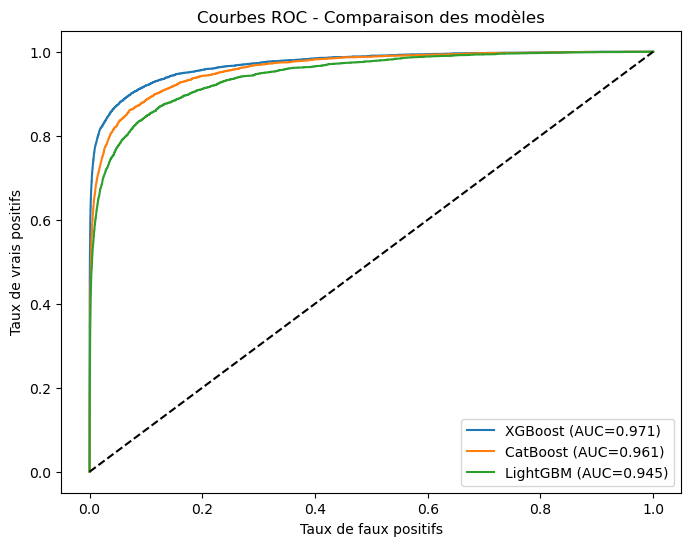

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, data in metrics.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC={results[name]:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("Courbes ROC - Comparaison des modèles")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

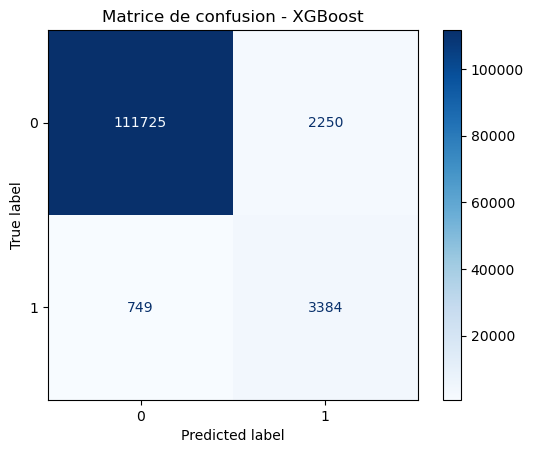

<Figure size 640x480 with 0 Axes>

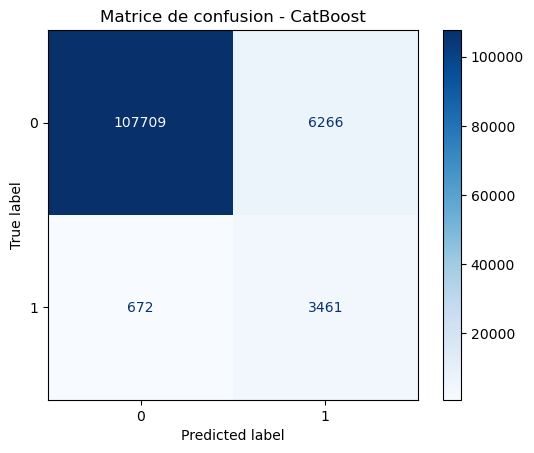

<Figure size 640x480 with 0 Axes>

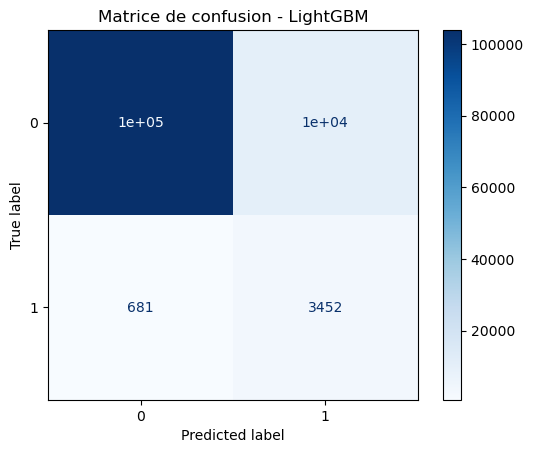

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, model_metrics in metrics.items():
    plt.figure()
    ConfusionMatrixDisplay(model_metrics['cm']).plot(cmap='Blues')
    plt.title(f"Matrice de confusion - {model_name}")
    plt.show()


In [50]:
metrics

{'XGBoost': {'fpr': array([0.        , 0.        , 0.        , ..., 0.99997368, 0.99999123,
         1.        ]),
  'tpr': array([0.00000000e+00, 2.41954996e-04, 3.43576095e-02, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
  'cm': array([[111725,   2250],
         [   749,   3384]])},
 'CatBoost': {'fpr': array([0.        , 0.        , 0.        , ..., 0.99961395, 0.9996315 ,
         1.        ]),
  'tpr': array([0.00000000e+00, 2.41954996e-04, 6.04887491e-03, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
  'cm': array([[107709,   6266],
         [   672,   3461]])},
 'LightGBM': {'fpr': array([0.        , 0.        , 0.        , ..., 0.99987717, 0.99998245,
         1.        ]),
  'tpr': array([0.00000000e+00, 2.41954996e-04, 3.38736995e-03, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
  'cm': array([[103894,  10081],
         [   681,   3452]])}}

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'DeviceType', 'DeviceInfo', 'D1n', 'D2n', 'D3n', 'D4n', 'D5n', 'D10n',
       'D11n', 'D15n'],
      dtype='object', length=191)


In [59]:
# save df_train column names as a Python list in a .txt file
cols_list = df_train.columns.tolist()
with open("df_train_columns.txt", "w", encoding="utf-8") as f:
    f.write(str(cols_list))

print(f"Saved {len(cols_list)} column names to df_train_columns.txt")

Saved 191 column names to df_train_columns.txt
